# MODEL TRAINING

Inspired and built off of Readmission prediction modelling through Natural Language Processing from github code: https://github.com/andrewwlong/odsc_workshop

# Step 1. Prepare dataset for training

## Load the preprocessed dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_adm_notes_clean = pd.read_csv('./df_adm_notes_final.csv')

In [2]:
# put column of Readmission labels
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [3]:
print('Number of positive samples (<30 Day Readmissions):', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

Number of positive samples (<30 Day Readmissions): 3004
Number of negative samples: 48109
Total samples: 51113


In [4]:
# randomly shuffle data first
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 77)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

# 10% validation data and 10% test data 
df_valid_test=df_adm_notes_clean.sample(frac=0.20,random_state=77)
df_test = df_valid_test.sample(frac = 0.5, random_state = 77)
df_valid = df_valid_test.drop(df_test.index)

# 80% training data
df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

In [5]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all)))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 5112):0.059
Valid prevalence(n = 5111):0.057
Train all prevalence(n = 40890):0.059
all samples (n = 51113)


In [6]:
df_test.to_csv('./df_test.csv',index=False)
df_valid.to_csv('./df_valid.csv',index=False)

df_test = pd.read_csv('./df_test.csv')
df_valid = pd.read_csv('./df_valid.csv')

Perform data augmentation (oversampling, undersampling) to balance the data due to low prevalence in the training set

In [7]:
# split training to positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# minimum size of the two splits
n = np.min([len(df_train_pos),len(df_train_neg)])

# merge the balanced data
df_train = pd.concat([df_train_pos.sample(n = n, random_state = 77), \
                      df_train_neg.sample(n = n, random_state = 77)],axis = 0)

# shuffle the training samples again
df_train = df_train.sample(n = len(df_train), random_state = 77).reset_index(drop = True)

# verify that prevalence is balanced now in the training set
print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4826): 0.5


In [8]:
# save the train, test, validation sets
df_train.to_csv('./df_train.csv',index=False)
df_train = pd.read_csv('./df_train.csv')

# Step 2. Preprocess Texts from Discharge Summaries

Use Bag-of-Words (BOW) approach - break up text into individual words & count up each word

In [9]:
# clean up known unnecessary formats in the summary texts
def clean_text(df):
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [10]:
df_train = clean_text(df_train)
df_valid = clean_text(df_valid)
df_test = clean_text(df_test)

In [11]:
import nltk
from nltk import word_tokenize
import string

# build a custom tokenizer that replaces punctuations and numbers with spaces, makes all words lowercase
def custom_token(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [12]:
# list comprehension to apply custom_token function to every text
df_train.TEXT = [custom_token(i) for i in df_train.TEXT]

Stopwords :  ['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'mg', 'in', 'for', 'tablet', 'no', 'name', 'is', 'po', 'patient', 's', 'he', 'blood', 'daily', 'at', 'sig', 'as', 'or', 'hospital', 'she', 'one', 'discharge', 'day', 'his', 'last', 'left', 'history', 'am', 'her', 'were', 'right', 'you', 'pt', 'not', 'by', 'pm', 'be', 'had', 'your', 'pain', 'this', 'admission', 'date']


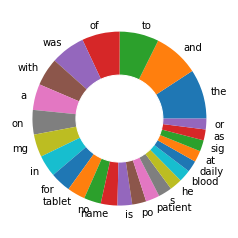

In [13]:
import itertools
from collections import Counter
from matplotlib import cm

## Extract commonly used words
words = Counter(i for i in list(itertools.chain.from_iterable(df_train.TEXT)))
top_words = words.most_common(50)
stopwords,count = map(list,zip(*top_words))
print("Stopwords : ",stopwords)

circle = plt.Circle((0,0),0.5,color = "white")
cs = cm.Set1(np.arange(25)/25.)
plt.pie(count[:25],labels = stopwords[:25])
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [14]:
# Vectorizer to draw features from text data
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 1000, 
                       tokenizer = custom_token, 
                       stop_words = stopwords)
df_train.TEXT = [' '.join(i) for i in df_train.TEXT]
vect.fit(df_train.TEXT)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'mg', 'in', 'for', 'tablet', 'no', 'name', 'is', 'po', 'patient', 's', 'he', 'blood', 'daily', 'at', 'sig', 'as', 'or', 'hospital', 'she', 'one', 'discharge', 'day', 'his', 'last', 'left', 'history', 'am', 'her', 'were', 'right', 'you', 'pt', 'not', 'by', 'pm', 'be', 'had', 'your', 'pain', 'this', 'admission', 'date'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function custom_token at 0x000001C1B46C08C8>,
        vocabulary=None)

In [15]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

# Step 3. Modeling

A simple logistic regression was chosen, as suggested from the statement, "In natural language processing, logistic regression is the baseline supervised machine learning algorithm for classification, and also has a very close
relationship with neural networks," from Jurafsky and Martin (https://web.stanford.edu/~jurafsky/slp3/5.pdf).

Parameter tunings were done on the number of features and the inverse regularization strength using a range of values for each parameter using for loops. Based on the returned AUC values of validation set, the parameter value that returned the highest amongst all was chosen to be used in the final model run. In addition, other performance metrics, such as accuracy, recall, precision, and specificity were computed for the final model.

In [16]:
# simple logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 77, max_iter=1000)
clf.fit(X_train_tf, y_train)

C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=77,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [17]:
y_train_preds = clf.predict_proba(X_train_tf)[:,1]
y_valid_preds = clf.predict_proba(X_valid_tf)[:,1]
y_test_preds = clf.predict_proba(X_test_tf)[:,1]
print(y_train[:10].values)
print('y_train_preds',y_train_preds[:10])
print(y_valid[:10].values)
print('y_valid_preds',y_valid_preds[:10])
print(y_test[:10].values)
print('y_test_preds',y_test_preds[:10])

[0 0 1 1 1 0 0 1 1 0]
y_train_preds [0.51639842 0.67184582 0.55044169 0.48487768 0.6920366  0.59306616
 0.45911095 0.50469508 0.50493512 0.51671693]
[0 0 0 0 0 0 0 0 0 0]
y_valid_preds [0.83897045 0.4055844  0.39710769 0.41557073 0.49764603 0.44564399
 0.52217356 0.45977386 0.46889953 0.47459073]
[0 0 0 0 0 0 1 0 0 0]
y_test_preds [0.47871924 0.41932639 0.41843145 0.76549252 0.39644388 0.61478832
 0.4108972  0.45727495 0.50289758 0.50146156]


# Step 4. Hyperparameter Tuning

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# Try a range of inverse of regularization strength; smaller values specify stronger regularization.
CC = [0.005, 0.0001, 0.00005]
train_aucs = np.zeros(len(CC))
valid_aucs = np.zeros(len(CC))
test_aucs = np.zeros(len(CC))

for ii in range(len(CC)):
    C = CC[ii]
    print('\n C:', C)
    
    # logistic regression
    
    clf=LogisticRegression(C = C, penalty = 'l2', random_state = 77)
    clf.fit(X_train_tf, y_train)

    y_train_preds = clf.predict_proba(X_train_tf)[:,1]
    y_valid_preds = clf.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

OptStrength = 0.0001
# Optimized Inv Reg Strength that Maximize Val Acc: 0.0001


 C: 0.005


C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.913
Valid AUC:0.695

 C: 0.0001


C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.755
Valid AUC:0.697

 C: 5e-05
Train AUC:0.737
Valid AUC:0.693


C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [27]:
# Try different number of features
num_features = [1000,2000,3000,4000]
train_aucs = np.zeros(len(num_features))
valid_aucs = np.zeros(len(num_features))

for ii in range(len(num_features)):
    num = num_features[ii]
    print('\nnumber of features:', num)
    vect = CountVectorizer(lowercase = True, max_features = num, 
                           tokenizer = custom_token,stop_words =stopwords)

    # This could take a while
    vect.fit(df_train.TEXT.values)

    X_train_tf = vect.transform(df_train.TEXT.values)
    X_valid_tf = vect.transform(df_valid.TEXT.values)
    y_train = df_train.OUTPUT_LABEL
    y_valid = df_valid.OUTPUT_LABEL
    
    clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC: %.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

OptFeat = 3000
# Optimized Number of Features that Maximize Val Acc: 3000


number of features: 1000


C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.738
Valid AUC:0.687

number of features: 2000


C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.750
Valid AUC:0.695

number of features: 3000


C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.755
Valid AUC:0.697

number of features: 4000


C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.758
Valid AUC:0.698


# Step 5. Rerun Logistic Regression Model with Tuned Parameters

In [14]:
# Vectorizer to draw features from text data
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = custom_token, 
                       stop_words = stopwords)
df_train.TEXT = [' '.join(i) for i in df_train.TEXT]
vect.fit(df_train.TEXT)
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

In [15]:
# simple logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 77, max_iter=500)
clf.fit(X_train_tf, y_train)

C:\Users\Kim\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=77,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [16]:
y_train_preds = clf.predict_proba(X_train_tf)[:,1]
y_valid_preds = clf.predict_proba(X_valid_tf)[:,1]
y_test_preds = clf.predict_proba(X_test_tf)[:,1]
print(y_train[:10].values)
print('y_train_preds',y_train_preds[:10])
print(y_valid[:10].values)
print('y_valid_preds',y_valid_preds[:10])
print(y_test[:10].values)
print('y_test_preds',y_test_preds[:10])

[0 0 1 1 1 0 0 1 1 0]
y_train_preds [0.51107283 0.68266401 0.54889277 0.48188072 0.71540015 0.57873329
 0.46380461 0.51092805 0.48763449 0.51282263]
[0 0 0 0 0 0 0 0 0 0]
y_valid_preds [0.85013704 0.40763174 0.39290267 0.41504204 0.49774853 0.46075159
 0.52621078 0.46153866 0.47022739 0.47631434]
[0 0 0 0 0 0 1 0 0 0]
y_test_preds [0.46536408 0.40427086 0.42171994 0.77635747 0.38892903 0.61646612
 0.39633968 0.45454264 0.50328369 0.502804  ]


# Step 6. Performance Metrics

In [28]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def calc_sensitivity(y_actual, y_pred, thresh):
    # calculates sensitivity
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual ==1)

Train AUC:0.758
Valid AUC:0.698
Test AUC:0.677
Train accuracy:0.694
Valid accuracy:0.668
Test accuracy:0.671
Train recall:0.687
Valid recall:0.660
Test recall:0.590
Train precision:0.697
Valid precision:0.107
Test precision:0.102
Train specificity:0.702
Valid specificity:0.668
Test specificity:0.676
Train sensitivity:0.687
Valid sensitivity:0.660
Test sensitivity:0.590


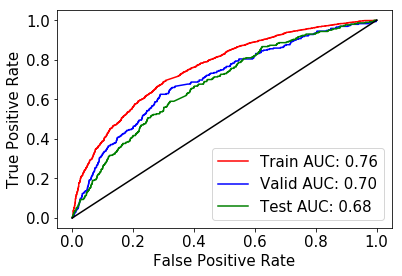

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%accuracy_score(y_train, y_train_preds >= thresh))
print('Valid accuracy:%.3f'%accuracy_score(y_valid, y_valid_preds >= thresh))
print('Test accuracy:%.3f'%accuracy_score(y_test, y_test_preds >= thresh))

print('Train recall:%.3f'%recall_score(y_train, y_train_preds>= thresh))
print('Valid recall:%.3f'%recall_score(y_valid, y_valid_preds>= thresh))
print('Test recall:%.3f'%recall_score(y_test, y_test_preds>= thresh))

print('Train precision:%.3f'%precision_score(y_train, y_train_preds>= thresh))
print('Valid precision:%.3f'%precision_score(y_valid, y_valid_preds>= thresh))
print('Test precision:%.3f'%precision_score(y_test, y_test_preds>= thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

print('Train sensitivity:%.3f'%calc_sensitivity(y_train, y_train_preds, thresh))
print('Valid sensitivity:%.3f'%calc_sensitivity(y_valid, y_valid_preds, thresh))
print('Test sensitivity:%.3f'%calc_sensitivity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate',fontsize = 15)
plt.ylabel('True Positive Rate',fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [19]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

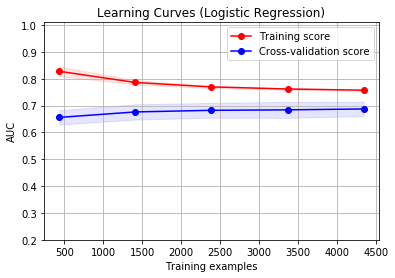

In [20]:
title = "Learning Curves (Logistic Regression)"
# Use 5-fold cross-validation
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=77)
estimator = LogisticRegression( C = 0.0001, penalty = 'l2')#
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=5)

plt.show()

# Step 7. Visualize Feature Importance

In [21]:
feature_importances = pd.DataFrame(clf.coef_[0],
                                   index = vect.get_feature_names(),
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

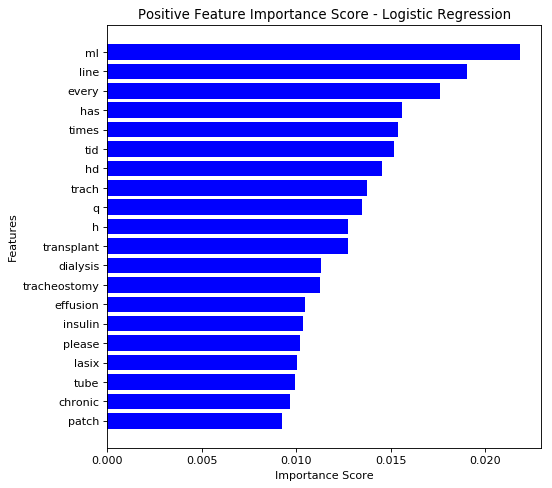

In [30]:
# top 20 positive features (those related to predicting readmission <30 days)
num = 20
ylocs = np.arange(num)
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center', color = 'blue')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

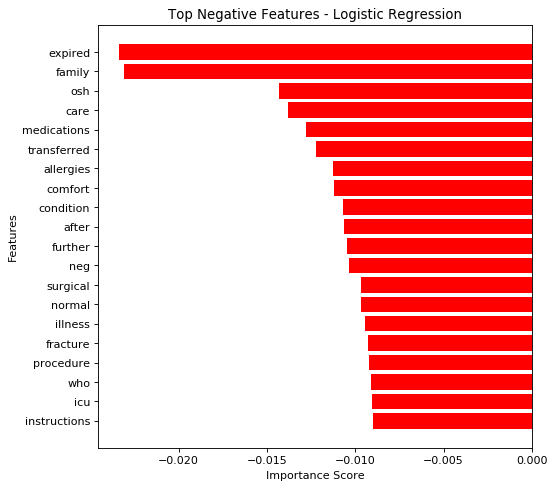

In [31]:
# top 20 positive features (those related to predicting NO readmission <30 days)
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center', color = 'red')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Top Negative Features - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

# Suggestions:

Overall, the model performed reasonably well, obtaining validation and test accuracies of roughly 70%. In real clinical settings, though further optimizations and improvements must be made, this model may be applied by asking the clinician for a current status report of the patient during their stay, which can then be text-tokenized and run through the model to give a probability of whether it is more likely that the patient would readmit within 30 days if he/she left right now or not. If the returned probability is very high, then extra care may be considered for the patient.

Perhaps for a future work, Natural Language Processing may be used on Nurse reports (also in NoteEvents.csv). I was cautious about using this particular text data, as looking at some samples from MIMIC-III, they seemed to revolve more on lab test results and recording of future plans for the patients. However, it may be that this information also has some predictive power, so testing the model with this data instead may be worth simulating. In addition, the number of features, inclusion/exclusion of certain stopwords, and inverse regularization strength all can be further calibrated for optimal performance, given more time.